In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from dedalus import public as de

import logging
logger = logging.getLogger(__name__)

In [2]:
'''
     Estimate atmospheric parameters based on properties of
     a single polytrope in the convection zone and a second
     one in the radiative zone.
'''
# Thanks:
# http://stackoverflow.com/questions/1408818/getting-the-the-keyword-arguments-actually-passed-to-a-python-method
# and
# https://docs.python.org/3.4/library/inspect.html#inspect.getfullargspec
def keyword_wrapper(f):
    import inspect
    sig = inspect.signature(f)
    print("sig: {}".format(sig))
    #kw_dict = dict(sig)
    #print(kw_dict)

#@keyword_wrapper
def compute_atmosphere_parameters(Rayleigh_top=1e8, Prandtl_top=1, gamma=5/3,
                                  n_rho_cz=3, n_rho_rz=2, 
                                  m_rz=3, stiffness=100):
    # inputs:
    # Rayleigh_top = g dS L_cz**3/(chi_top**2 * Pr_top)
    # Prandtl_top = nu_top/chi_top
    # gamma = c_p/c_v
    # n_rho_cz = ??
    # n_rho_rz = ??
    # m_rz = polytropic index of radiative zone
    # stiffness = (m_rz - m_ad)/(m_ad - m_cz)
    
    # this is not a totally awesome solution,
    # but inspect.signature and inspect.getfullargspec
    # are failing to get the actual entered values (vs. defaults)
    # this will choke if we have imports.
    #
    # This only gets the kwargs if it's the first thing called
    entered_parameters = locals()
    
    m_ad = 1/(gamma-1)
    
    epsilon = (m_rz - m_ad)/stiffness
    m_cz = m_ad - epsilon
    
    kappa_ratio = (m_rz + 1)/(m_cz + 1)

    # T = del_T*(z-z_interface) + T_interface
    # del_T = -g/(m+1) = -(m_cz+1)/(m+1)
    # example: cz: z_interface = L_cz (top), T_interface = 1, del_T = -1
    #     .: T = -1*(z - L_cz) + 1 = (L_cz + 1 - z) = (z0 - z)
    # this recovers the Lecoanet et al 2014 notation
    #
    # T_bot = -del_T*z_interface + T_interface
    # n_rho = ln(rho_bot/rho_interface) = m*ln(T_bot/T_interface)
    #       = m*ln(-del_T*z_interface/T_interface + 1)
    # 
    # z_interface = (T_interface/(-del_T))*(np.exp(n_rho/m)-1)
    L_cz = np.exp(n_rho_cz/m_cz)-1
    
    del_T_rz = -(m_cz+1)/(m_rz+1)
    T_interface = (L_cz+1) # T at bottom of CZ
    L_rz = T_interface/(-del_T_rz)*(np.exp(n_rho_rz/m_rz)-1)

    L_tot = L_cz + L_rz
    
    z_cz = L_cz + 1
    
    delta_S = epsilon*(gamma-1)/gamma*np.log(z_cz)
    
    g = (m_cz + 1)
    
    chi_top = np.sqrt((g*delta_S*L_cz**3)/(Rayleigh_top*Prandtl_top))
    nu_top = chi_top*Prandtl_top
    
    parameters = dict()
    parameters['chi_top'] = chi_top
    parameters['nu_top']  = nu_top
    parameters['kappa_ratio'] = kappa_ratio
    parameters['L_cz'] = L_cz
    parameters['L_rz'] = L_rz
    parameters['L_tot'] = L_tot
    parameters['m_ad'] = m_ad
    parameters['m_cz'] = m_cz
    parameters['epsilon'] = epsilon
    parameters['delta_S'] = delta_S
    parameters['gamma'] = gamma
    parameters['g'] = g

    parameters.update(entered_parameters)
    
    return parameters

In [3]:
def compute_kappa_profile(parameters, z, kappa, tanh_width=0.1):

    tanh_center = parameters['L_rz']
    kappa_top = parameters['chi_top']
    kappa_ratio = parameters['kappa_ratio']
    
    phi = (1/2*(1-np.tanh((z-tanh_center)/tanh_width)))
    inv_phi = 1-phi
    kappa['g'] = (phi*kappa_ratio+inv_phi)*kappa_top
    logger.debug("kappa ratio: {}".format(kappa['g'][0]/kappa['g'][-1]))

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(z, phi)
    ax.plot(z, inv_phi)
    ax.plot(z, phi+inv_phi, linestyle='dashed')
    ax.set_ylim(0,1.1)
    ax.set_xlabel('z')
    ax.set_ylabel(r'$\Phi$(z)')
    

In [4]:
def multi_polytrope(parameters, show_plots=True):

    Lz = parameters['L_tot']
    z_basis = de.Chebyshev('z', 1024, interval=(0, Lz), dealias=3/2)
    domain = de.Domain([z_basis], grid_dtype=np.float64)
    z = domain.grid(0)

    epsilon = parameters['epsilon']
    m_ad = parameters['m_ad']
    m_cz = parameters['m_cz']
    m_rz = parameters['m_rz']

    kappa = domain.new_field()
    del_T = domain.new_field()
    T = domain.new_field()
    
    compute_kappa_profile(parameters, z, kappa)        
    
    flux_top = -parameters['chi_top']
    del_T['g'] = flux_top/kappa['g']
    
    del_T.antidifferentiate('z',('right',0), out=T)
    T['g'] += 1
    T.set_scales((1,), keep_data=True)
    z_dealias = domain.grid(axis=0, scales=domain.dealias)
    
    g = parameters['g']
    del_ln_P = domain.new_field()
    ln_P = domain.new_field()
    P = domain.new_field()

    # assumes ideal gas equation of state
    del_ln_P['g'] = g/T['g']
    del_ln_P.antidifferentiate('z',('right',0),out=ln_P)
    ln_P.set_scales(1, keep_data=True)
    P['g'] = np.exp(-ln_P['g'])

    rho = domain.new_field()
    rho['g'] = P['g']/T['g']
    rho.set_scales(1, keep_data=True)
    
    if show_plots:
        fig = plt.figure()
        ax1 = fig.add_subplot(2,1,1)
        ax1.plot(z, T['g'])
        ax1.set_ylabel("T")
        ax1.set_xlabel("z")
    
        #fig = plt.figure()
        ax2 = fig.add_subplot(2,1,2)
        ax2.semilogy(z, rho['g'])
        ax2.semilogy(z, P['g'])
        ax2.set_ylabel("rho and P")
        ax2.set_xlabel("z")
        
        grad_ln_rho = domain.new_field()
        rho.differentiate('z', out=grad_ln_rho)
        grad_ln_rho['g'] /= rho['g']
        rho.set_scales(1, keep_data=True)
        grad_ln_rho.set_scales(1, keep_data=True)
        
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(z, grad_ln_rho['g'])
        ax1.set_ylabel(r'$\nabla \ln \rho$')
        ax1.set_xlabel('z')
        
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(z, kappa['g'])
        ax1.set_ylabel(r'$\kappa$')
        ax1.set_xlabel('z')
        

    n_rho = np.log(rho['g'][0]/rho['g'][-1])
    target_n_rho = parameters['n_rho_cz']+parameters['n_rho_rz']
    logger.info("n_rho        = {}".format(n_rho))
    logger.info("target n_rho = {}".format(target_n_rho))
    logger.info("n_rho_error  = {}".format(n_rho/target_n_rho-1))
    logger.info("n_P = {}".format(np.log(P['g'][0]/P['g'][-1])))

    # error in hydrostatic balance diagnostic
    del_P = domain.new_field()
    P.differentiate('z', out=del_P)
    del_P.set_scales(1, keep_data=True)
    HS_balance = del_P['g']+g*rho['g']

    if show_plots:
        fig = plt.figure()
        ax1 = fig.add_subplot(2,1,1)
        ax1.plot(z, del_P['g'])
        ax1.plot(z, -g*rho['g'])
        ax1.set_ylabel(r'$\nabla P$ and $\rho g$')
        ax1.set_xlabel('z')
        
        ax2 = fig.add_subplot(2,1,2)
        ax2.semilogy(z, np.abs(HS_balance/del_P['g']))
        ax2.set_ylabel(r'$|\nabla P + \rho g |/|del P|$')
        ax2.set_xlabel('z')
        
    logger.info('max error in HS balance: {}'.format(np.max(np.abs(HS_balance/del_P['g']))))

DEBUG:domain:Global coeff shape: [1024]
DEBUG:distributor:Mesh: []
DEBUG:__main__:kappa ratio: 1.600096005760346
DEBUG:problems:Parsing Eqn 0
DEBUG:problems:  Condition: True
DEBUG:problems:  LHS string form: dz(out)
DEBUG:problems:  RHS string form: f
DEBUG:problems:  LHS object form: dz(out)
DEBUG:problems:  RHS object form: f
DEBUG:problems:  L linear form: dz(out)
DEBUG:problems:Parsing BC 0
DEBUG:problems:  Condition: True
DEBUG:problems:  LHS string form: right(out)
DEBUG:problems:  RHS string form: bc
DEBUG:problems:  LHS object form: interp(out,'z',right)
DEBUG:problems:  RHS object form: bc
DEBUG:problems:  L linear form: interp(out,'z',right)
DEBUG:solvers:Beginning LBVP instantiation
INFO:pencil:Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s


L_cz  : 6.390534205766878
L_rz  : 11.207489806803213
L_tot : 17.598024012570093
2015-06-29 17:05:36,338 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s


DEBUG:solvers:Finished LBVP instantiation
DEBUG:basis:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (1024,), 0)
DEBUG:basis:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (1536,), 0)
DEBUG:problems:Parsing Eqn 0
DEBUG:problems:  Condition: True
DEBUG:problems:  LHS string form: dz(out)
DEBUG:problems:  RHS string form: f
DEBUG:problems:  LHS object form: dz(out)
DEBUG:problems:  RHS object form: f
DEBUG:problems:  L linear form: dz(out)
DEBUG:problems:Parsing BC 0
DEBUG:problems:  Condition: True
DEBUG:problems:  LHS string form: right(out)
DEBUG:problems:  RHS string form: bc
DEBUG:problems:  LHS object form: interp(out,'z',right)
DEBUG:problems:  RHS object form: bc
DEBUG:problems:  L linear form: interp(out,'z',right)
DEBUG:solvers:Beginning LBVP instantiation
INFO:pencil:Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+01/s


2015-06-29 17:05:36,463 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+01/s


DEBUG:solvers:Finished LBVP instantiation
INFO:__main__:n_rho        = 5.002995185469547


2015-06-29 17:05:36,665 __main__ 0/1 INFO :: n_rho        = 5.002995185469547


INFO:__main__:target n_rho = 5


2015-06-29 17:05:36,666 __main__ 0/1 INFO :: target n_rho = 5


INFO:__main__:n_rho_error  = 0.0005990370939092937


2015-06-29 17:05:36,667 __main__ 0/1 INFO :: n_rho_error  = 0.0005990370939092937


INFO:__main__:n_P = 7.669238537872771


2015-06-29 17:05:36,668 __main__ 0/1 INFO :: n_P = 7.669238537872771


INFO:__main__:max error in HS balance: 1.1157523039169397e-08


2015-06-29 17:05:36,774 __main__ 0/1 INFO :: max error in HS balance: 1.1157523039169397e-08


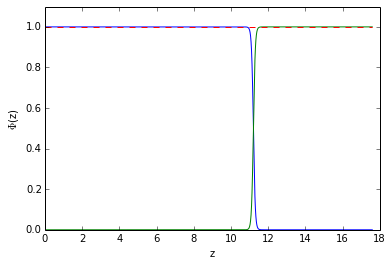

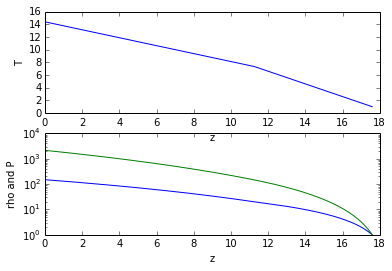

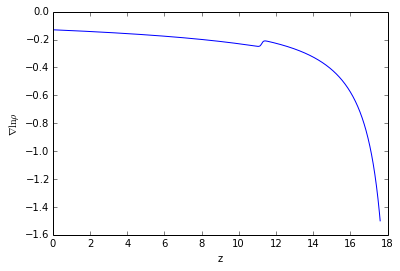

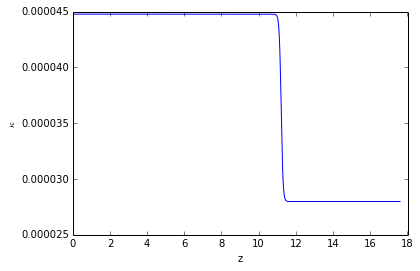

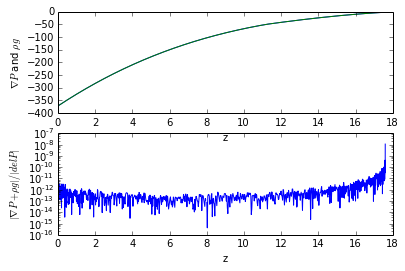

In [5]:
parameters = compute_atmosphere_parameters(stiffness=1e4, 
                                           n_rho_cz=3, 
                                           n_rho_rz=2)
#for key in parameters.keys():
#    print("{} : {}".format(key, parameters[key]))
print("L_cz  : {}".format(parameters['L_cz']))
print("L_rz  : {}".format(parameters['L_rz']))
print("L_tot : {}".format(parameters['L_tot']))
multi_polytrope(parameters, show_plots=True)